# Tera - Desafio de interpretação e predição do valor de venda de imóveis

## Introdução e contexto

Esse código apresenta uma resolução para o desafio de regressão proposto durante o curso de Data Science e Machine Learning da Tera. O conjunto de dados descreve a venda de propriedades residenciais individuais de uma cidade americana, entre 2006 e 2010. São 2.930 observações e um npumero considerável de features (23 nominais, 23 ordinais, 14 discretas e 20 contínuas). O dataset tem, ao todo, 80 variáveis explicativas para a determinação do valor do imóvel.

Esse trabalho é dividido em duas partes: Em um primeiro momento é realizada a análise exploratória dos dados, além das feature engineering para organização e manutenção das variáveis. Depois, são apresentadas leituras realizadas a partir de modelos de Machine Learning, usando algorítmos de regressão e emsembles. 

Grandes agradecimentos à equipe da Tera, em especial ao expert Marcus Oliveira, que foi de grande ajuda na solução do problema.

## 1. Configurações iniciais

### 1.1 Importação das bibliotecas que serão utilizas ao longo do código

In [1]:
#Core
import numpy as np
import pandas as pd
from typing import List, Tuple
import math

#Plot
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import seaborn as sns

#Estatística - Modelo de interpretação
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api         as sm
import statsmodels.formula.api as smf

#Criação do modelo de Machine Learning
from sklearn.impute import SimpleImputer
from category_encoders.target_encoder import TargetEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split 

### 1.2 Elaboração de algumas funções utilizadas posteriormente no código

In [2]:
def plota_cat(variaveis: list, figsize: tuple, dataframe: pd.DataFrame()) -> plt.figure:
    '''Dada uma lista de variáveis categóricas, plota uma figura
       com os gráficos de violino de todas as variáveis na lista'''
    total_plots = len(variaveis)
    i = 0

    fig = plt.figure(figsize=figsize)
    fig.subplots_adjust(hspace=0.8, wspace=0.3)


    for var in variaveis:
        ax = fig.add_subplot(total_plots, 2, i+1)

        sns.violinplot(x=var, y=var_resp, data=df, ax=ax, color='#435058')
        ax.set_title(var)
        ax.set_ylabel('')
        ax.set_xlabel('')
        if dataframe[var].nunique() > 6:
            ax.xaxis.set_tick_params(rotation=90)
        i += 1


def calc_vif(dataframe: pd.DataFrame()) -> pd.DataFrame():
    '''Calcula o VIF para identificar multicolinearidade'''
    vif = pd.DataFrame()
    vif['variables'] = dataframe.columns
    vif['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return(vif)

def plot_vif(vif: pd.DataFrame()) -> None:
    '''Apresenta a soma do VIF'''
    print('vars: ', list(vif.columns))
    print('Variable Inflation Factors:', vif.VIF.sum(), '\n')

def train_test_valid_split(df: pd.DataFrame, features: list, target: str, test_size: float, valid_size: float, random_state: int) -> Tuple[np.array, np.array, np.array, np.array, np.array, np.array]:
    '''Cria os folds de treino, teste e validação'''

    #Treino e teste
    (X_train, X_test, y_train, y_test) = train_test_split(
        df[features],
        df[target],
        test_size=test_size,
        random_state=random_state,
    )

    #Validação
    (X_test, X_val, y_test, y_val) = train_test_split(
        X_test, y_test, test_size=valid_size, random_state=random_state
    )

    return X_train, X_test, X_val, y_train, y_test, y_val

def metrics_report(y: pd.Series(), y_pred: pd.Series(), dataset_name='valid') -> pd.DataFrame():
  '''Cria um dataframe contendo as
     principais métricas do modelo de
     Machine Learning criado'''
  
  mean_y = np.mean(y)
  mean_pred = np.mean(y_pred)

  rmse = round(math.sqrt(mean_squared_error(y, y_pred)), 2)
  mae = mean_absolute_error(y, y_pred)
  r2 = r2_score(y, y_pred)
  mape = mean_absolute_percentage_error(y, y_pred)
  
  report = pd.DataFrame({
    'metric': ['RMSE', 'MAE', 'R^2', 'MAPE', 'Avg. target', 'Avg. Prediction'],
    dataset_name: [rmse, mae, r2, mape, mean_y, mean_pred]
  })

  report[dataset_name] = report[dataset_name].round(2)
  return report

def random_forest_preprocessing(X_train: pd.DataFrame(), X_val: pd.DataFrame(), X_test: pd.DataFrame(), y_train: pd.Series(), categoricas: list) -> pd.DataFrame():

  '''Realiza o pré-processamento das variáveis categóricas utilizadas
    no algoritmo de RandomForest. O pré-processamento é realizado através
    do método de target Encodding'''
    
  target_encoder = TargetEncoder()
  X_train[categoricas] = target_encoder.fit_transform(X_train[categoricas], y_train)
  X_val[categoricas] = target_encoder.transform(X_val[categoricas])
  X_test[categoricas] = target_encoder.transform(X_test[categoricas])

  return X_train, X_val, X_test



## 2. EDA da base original

In [3]:
#Carregamento da base original
df = pd.read_csv('base.csv', skipinitialspace=True)

#Verificando as informações sobre nulos e tipo de cada coluna no dataframe
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    1460 non-null   int64  
 1   ClasseImovel          1460 non-null   int64  
 2   ClasseZona            1460 non-null   object 
 3   Fachada               1201 non-null   float64
 4   TamanhoLote           1460 non-null   int64  
 5   Rua                   1460 non-null   object 
 6   Beco                  91 non-null     object 
 7   FormaProp             1460 non-null   object 
 8   PlanoProp             1460 non-null   object 
 9   Servicos              1460 non-null   object 
 10  ConfigLote            1460 non-null   object 
 11  InclinacaoLote        1460 non-null   object 
 12  Bairro                1460 non-null   object 
 13  Estrada1              1460 non-null   object 
 14  Estrada2              1460 non-null   object 
 15  TipoHabitacao        

### 2.1 Anotação da variável resposta e das features numéricas e categóricas (cardinais e ordinais)

In [4]:
#Variável resposta
var_resp = 'PrecoVenda'

#Lista das variáveis numéricas
var_num = df.select_dtypes(include=["int", "float"]).columns.to_list()
var_num.remove(var_resp)
var_num.remove('ClasseImovel') #Removida pois é categórica

#Lista das variáveis categóricas
v_cat = df.select_dtypes(exclude=["int", "float"]).columns.to_list()
v_cat.append('ClasseImovel')

#Distinção das variáveis categóricas, a diferenciação entre cardinais e ordinais nesse caso foi realizada para facilitar a visualização dos gráficos
v_cat_ord = ['FormaProp', 'Servicos', 'InclinacaoLote', 'Qualidade', 'Condicao', 'QualidadeCobertura', 'CondicaoExterna', 'AlturaPorao', 'CondicaoPorao', 'ParedePorao', 'TipoAcabPorao1', 'TipoAcabPorao2', 'QualidadeAquecimento', 'QualidadeCozinha', 'QualdiadeLareira', 'AcabamentoGaragem', 'QualidadeGaragem', 'CondicaoGaragem', 'EntradaPavimentada']
v_cat_card = [x for x in v_cat if x not in v_cat_ord]


### 2.2 Entendendo a distribuição da variável resposta

Para efeito de comparação, são feitos os gráficos de distribuição da variável reposta nas formas original e logarítmica. Como há grande diferença entre as duas bases, uma vez que variável em base logaritmica possui distribuição mais próxima à normal, é a mais correta para o trabalho no modelo de interpretação por regressão linear. A escolha procura diminuir os possíveis erros causados pelos outliers no valor do imóvel.

In [5]:
#Criando uma variável com o log dos preços para verificar diferenças entre a distribuição da variável em forma comum e logarítimica 
df['logPrecoVenda'] = np.log(df[var_resp])

#Verificando graficamente a distribuição das variáveis
fig = make_subplots(rows= 2, cols=2, subplot_titles=["Distribuição da variável PrecoVenda", "Distribuição da variável logPrecoVenda", "Area Contruida x Preço de Venda", "Área construída x log Preço de Venda"])\
    .add_trace(go.Histogram(x = df[var_resp]), row=1,col=1)\
    .add_trace(go.Histogram(x = df['logPrecoVenda']), row=1, col=2)\
    .add_trace(go.Scatter(x=df[var_resp], y=df['AreaConstruida'], mode='markers', showlegend=True), row=2, col=1)\
    .add_trace(go.Scatter(x=df['logPrecoVenda'], y=df['AreaConstruida'], mode='markers'), row=2, col=2)\
    .update_layout(width=1200, height=600)\
    .update_yaxes(title_text=('Teste1', 'Teste1', 'Teste1', 'Teste1'), row=(1,1,2,2), col=(1,2,1,2))\
    .show()



### 2.3 Variáveis categóricas: Examinando relações entre as categorias e alterações no valor das residências

São criados gráficos violinos de todas as variáveis para entender quais dessas têm diferenciações mais significativas no valor do imóvel. As variáveis com maior impacto no valor podem ser as mais interessantes para utilização no modelo. 

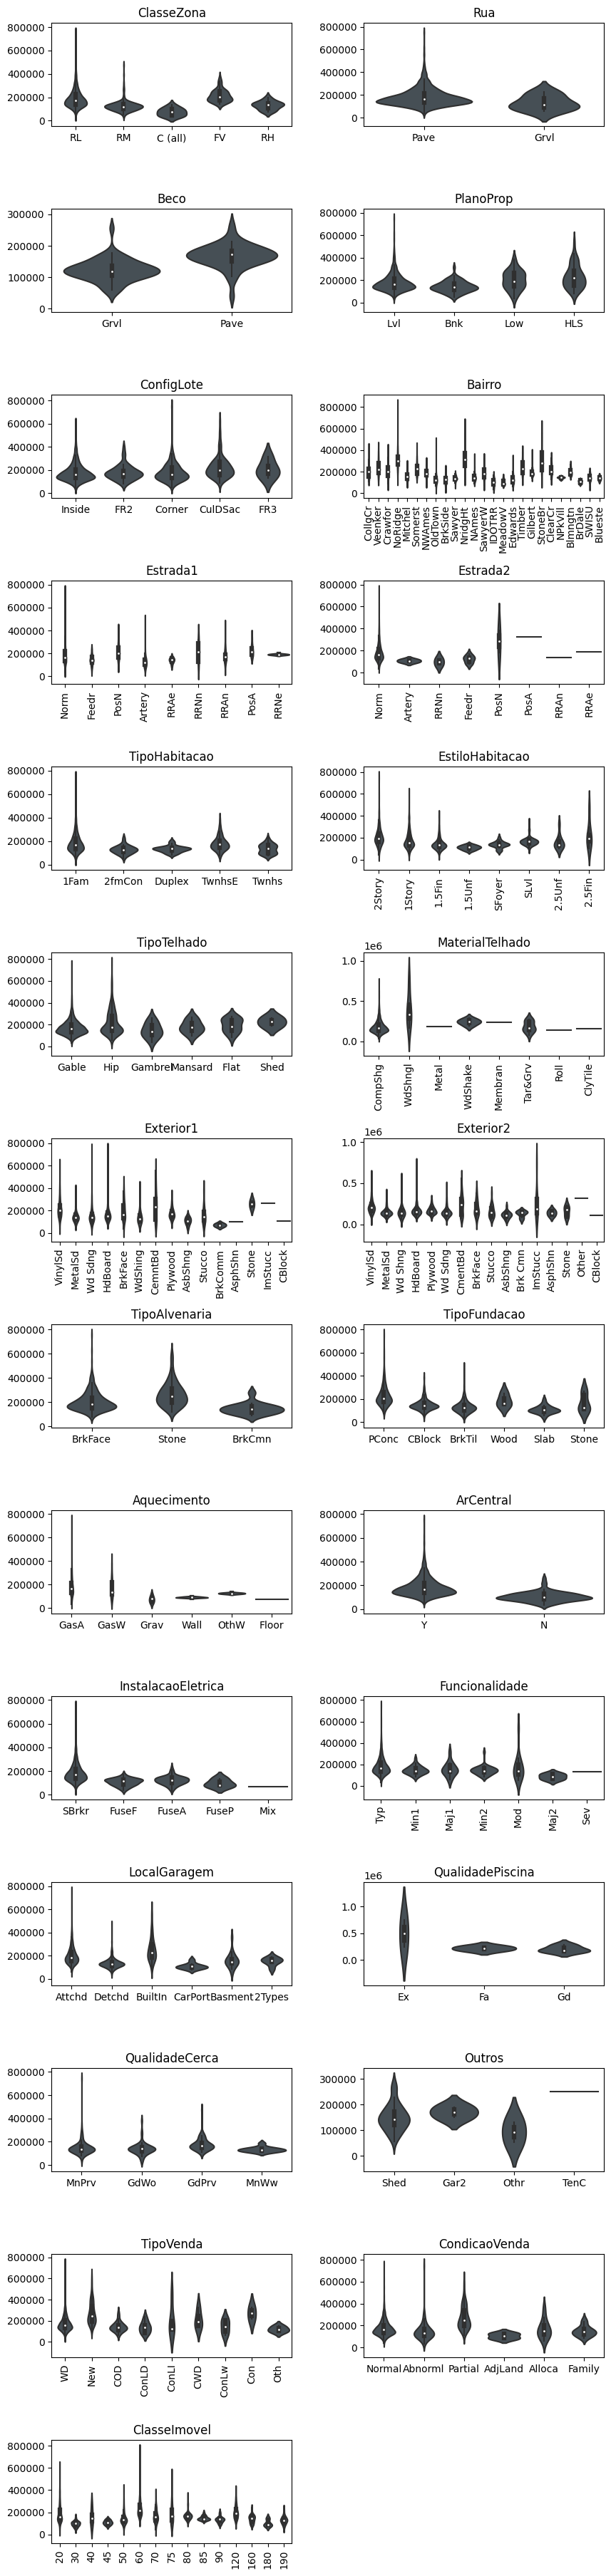

In [6]:
plota_cat(variaveis=v_cat_card, figsize=(10,90), dataframe=df)

In [7]:
#Verificando o grau de cardinalidade das variáveis categóricas
df[v_cat].nunique().sort_values(ascending=False)

Bairro                  25
Exterior2               16
ClasseImovel            15
Exterior1               15
Estrada1                 9
TipoVenda                9
MaterialTelhado          8
EstiloHabitacao          8
Estrada2                 8
Funcionalidade           7
TipoAcabPorao1           6
LocalGaragem             6
TipoTelhado              6
CondicaoVenda            6
Aquecimento              6
TipoFundacao             6
TipoAcabPorao2           6
QualdiadeLareira         5
QualidadeGaragem         5
CondicaoGaragem          5
InstalacaoEletrica       5
QualidadeAquecimento     5
ClasseZona               5
ConfigLote               5
TipoHabitacao            5
CondicaoExterna          5
FormaProp                4
Outros                   4
QualidadeCerca           4
PlanoProp                4
ParedePorao              4
QualidadeCozinha         4
QualidadeCobertura       4
AlturaPorao              4
CondicaoPorao            4
InclinacaoLote           3
AcabamentoGaragem        3
T

## 3. Feature Engineering

### 3.1 Removendo Nulos

São removidas variáveis com valores muito altos de inputs nulos. Os dados nulos de outras variáveis são inputados a partir da mediana do conjunto para valores numéricos ou do input mais frequente para valores categóricos

In [8]:
df = df.drop(['QualidadePiscina', 'Outros', 'Beco', 'QualidadeCerca', 'QualdiadeLareira'], axis=1)
nulos_categoricas = []
nulos_numericas = []

for col in df:
    if df[col].isna().sum() != 0:
        print('{}: {} nulos'.format(col,df[col].isna().sum()))
        nulos_numericas.append(col) if df[col].dtype == 'float64' else nulos_categoricas.append(col) #Cria listas com as colunas que tem inputs nulos, é importante para o mascaramento


Fachada: 259 nulos
TipoAlvenaria: 872 nulos
AreaAlvenaria: 8 nulos
AlturaPorao: 37 nulos
CondicaoPorao: 37 nulos
ParedePorao: 38 nulos
TipoAcabPorao1: 37 nulos
TipoAcabPorao2: 38 nulos
InstalacaoEletrica: 1 nulos
LocalGaragem: 81 nulos
AnoGaragem: 81 nulos
AcabamentoGaragem: 81 nulos
QualidadeGaragem: 81 nulos
CondicaoGaragem: 81 nulos


Como alguns modelos de Machine Learning não aceitam colunas com valores nulos, é realizado um mascaramento em todas as colunas que tem valores vazios. O mascaramento é feito com o método "SimpleImputer" e preenche as colunas com os valores medianos (no caso de colunas numéricas) ou com os valores mais frequentes (para o caso de colunas categóricas)

In [9]:
#Criando os recortes
num_com_nulos = df[nulos_numericas] 
cat_com_nulos = df[nulos_categoricas]

#Criando os inputers
mascara1 = SimpleImputer(missing_values=np.nan, strategy='median').fit(num_com_nulos)
mascara2 = SimpleImputer(missing_values=np.nan, strategy='most_frequent').fit(cat_com_nulos)

#Substituindo os valores nulos do recorte pelos inputers
df[nulos_numericas] = mascara1.transform(num_com_nulos) 
df[nulos_categoricas] = mascara2.transform(cat_com_nulos)

### 3.2 Removendo colunas categóricas com alta cardinalidade

Optei pela remoção das colunas com alta cardinalidade ou sem interpretação interessante apenas para simplificação da leitura dos modelos posteriores. Outras situações podem pedir o agrupamento dessas variáveis ou outro tipo de trabalho.

In [10]:
df = df.drop(['Bairro','Exterior1','Exterior2','ClasseImovel','Funcionalidade', 'Estrada1', 'Estrada2', 'MesVenda', 'ValorOutros'], axis=1)

Nesse notebook trabalho com imóveis vendidos sob condição normal, uma vez que são os mais recorrentes e interessante para a análise. Além disso, imóveis vendidos sob outras condições podem distorcer a análise significativamente.

In [11]:
df = df.query("CondicaoVenda == 'Normal'")
df.drop('CondicaoVenda', axis=1)

,Id,ClasseZona,Fachada,TamanhoLote,Rua,FormaProp,PlanoProp,Servicos,ConfigLote,InclinacaoLote,...,AreaDeck,AreaVarandaAberta,AreaVarandaFechada,AreaVaranda3Estacoes,AreaAlpendre,AreaPiscina,AnoVenda,TipoVenda,PrecoVenda,logPrecoVenda
0,1,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,61,0,0,0,0,2008,WD,208500,12.247694
1,2,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,...,298,0,0,0,0,0,2007,WD,181500,12.109011
2,3,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,0,42,0,0,0,0,2008,WD,223500,12.317167
4,5,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,...,192,84,0,0,0,0,2008,WD,250000,12.429216
5,6,RL,85.0,14115,Pave,IR1,Lvl,AllPub,Inside,Gtl,...,40,30,0,320,0,0,2009,WD,143000,11.870600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,40,0,0,0,0,2007,WD,175000,12.072541
1456,1457,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,349,0,0,0,0,0,2010,WD,210000,12.254863
1457,1458,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,0,60,0,0,0,0,2010,WD,266500,12.493130
1458,1459,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,Gtl,...,366,0,112,0,0,0,2010,WD,142125,11.864462


As variáveis de área estão em pés quadrados, uma notação mais difícil de entender. Para facilitar a visualização dos dados, converti as áreas para m².

In [12]:
area_features = [var for var in var_num if 'area' in var.lower()]
converte_m2 = lambda x: x*0.0929

df[area_features] = df[area_features].apply(converte_m2)
df[['Fachada', 'TamanhoLote']] = df[['Fachada', 'TamanhoLote']].apply(converte_m2)

Criei novas variáveis a partir da manipulação de colunas existentes.
- *Taxa_Ocupacao_Lote*: A taxa de ocupação diz quanto do lote do terreno é ocupado pela projeção do edifício.
- *Coeficiente_Aproveitamento*: O coeficiente de aproveitamento é uma relação entre a área construída e a área do terreno. É um quantitativo importante para o mercado imobiliário, uma vez que empreendimentos com melhor CA conseguem ter mais unidades e provavelmente uma melhor rentabilidade.
- *Ultima_Reforma*: Quantidade em anos desde a última reforma, espera-se que habitações com reformas recentes tenham maior preço de venda.
- *Banheiros_por_Quarto*: Uma variável que indica quantos banheiros há na casa em relação ao número de quartos, uma casa com BpQ > 1 apresenta grandes chances de possuir 1 ou mais suítes, enquanto valores menores que 1 indicam quartos sem banheiro individual na casa.

In [13]:
df['Taxa_Ocupacao_Lote'] = df['AreaTerreo']/df['TamanhoLote'] 
df['Coeficiente_Aproveitamento'] = df['AreaConstruida']/df['TamanhoLote'] 
df['Ultima_Reforma'] = df['AnoReforma'] - df['AnoConstrucao']
df['Banheiros_por_Quarto'] = df['Banheiro']/df['TotalQuartos']

## 4. Criando um modelo de interpretação a partir de regressão linear

O desafio proposto pela Tera era o de criar um modelo de regressão linear que explicasse ao menos 85% da variação do preço, considerando um máximos de 6 variáveis.

### 4.1 Inserindo as variáveis e rodando o modelo de regressão linear

Primeiro é feito o encoding de variáveis categóricas para a utilização nos modelos de regressão, essas variáveis são utilizadas na fórmula para obtenção da regressão a partir da biblioteca statsmodel. A escolha da statsmodel ocorreu pela completude da informação da regressão.

O modelo responde 85,6% da variação dos preços. Todas as variáveis rejeitam a hipótese nula e são estatísticamente significantes.

Foram testadas algumas combinações para a regressão linear, mas para a melhor legibilidade do código só é apresentado o conjunto final das variáveis escolhidas.

In [14]:
#Realizando enconding de algumas variáveis categóricas que são testadas no modelo de regressão

df['QualidadeCozinha'] = df['QualidadeCozinha'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
df['AlturaPorao'] = df['AlturaPorao'].map({'Po':0, 'Fa':1, 'TA':2, 'Gd':3, 'Ex':4})
df[['QualidadeCozinha', 'AlturaPorao']] = df[['QualidadeCozinha', 'AlturaPorao']].astype(int)
df_dummies = pd.get_dummies(df, columns=['EstiloHabitacao', 'TipoHabitacao'], drop_first=True)

In [15]:
vars_reg = ["AreaConstruida","AreaPorao","Ultima_Reforma","CarrosGaragem","Condicao","Qualidade"]
formula ="logPrecoVenda ~ " + ' + '.join(vars_reg)

model = smf.ols(formula = formula, data = df_dummies).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          logPrecoVenda   R-squared:                       0.856
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     1185.
Date:                Thu, 31 Aug 2023   Prob (F-statistic):               0.00
Time:                        14:21:24   Log-Likelihood:                 664.68
No. Observations:                1198   AIC:                            -1315.
Df Residuals:                    1191   BIC:                            -1280.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         10.3111      0.030    348.

### 4.2 verificando multicolinearidade

A multicolinearidade entre as variáveis é verificada através do heatmap das variáveis escolhidas e do Variance Inflation Factor (VIF) entre as variáveis. É importante notar que o VIF foi de 97, muito acima do admitido em testes de maior rigor estatístico ou artigos, mas aceitável para o trabalho proposto.

<AxesSubplot: >

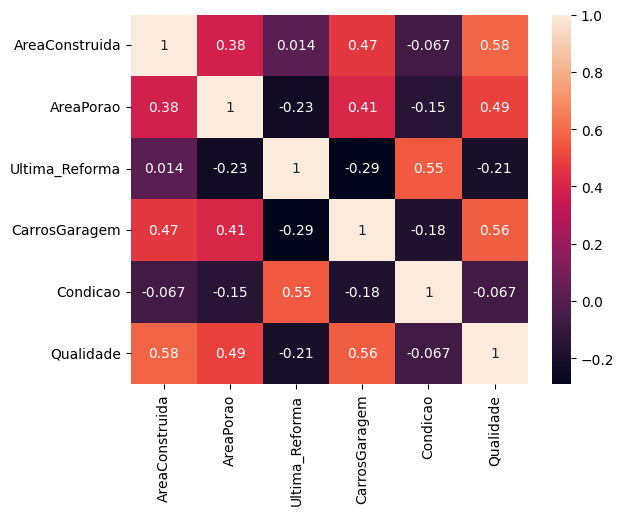

In [16]:
#Criando heatmap para verificação da colinearidade
sns.heatmap(df_dummies[["AreaConstruida","AreaPorao","Ultima_Reforma","CarrosGaragem","Condicao","Qualidade"]].corr(), annot=True)

In [17]:
#Variance Inflation Factor para verificar multicolinearidade entre as variáveis
vif = calc_vif(df_dummies[vars_reg])
print('vars: ', vars_reg)
print('Variable Inflation Factors:', vif.VIF.sum(), '\n')
vif

vars:  ['AreaConstruida', 'AreaPorao', 'Ultima_Reforma', 'CarrosGaragem', 'Condicao', 'Qualidade']
Variable Inflation Factors: 97.83204531842381 



,variables,VIF
0,AreaConstruida,16.931763
1,AreaPorao,10.528213
2,Ultima_Reforma,2.113803
3,CarrosGaragem,11.510602
4,Condicao,17.279173
5,Qualidade,39.468492


<h3>4.3 - Validando o modelo proposto a partir da análise dos resíduos</h3>

A distribuição dos erros é relativamente homoscedástica e os resíduos têm distribuição com alto grau de normalidade

Text(0.61, 0.95, '(VIF: 97.83204531842381)')

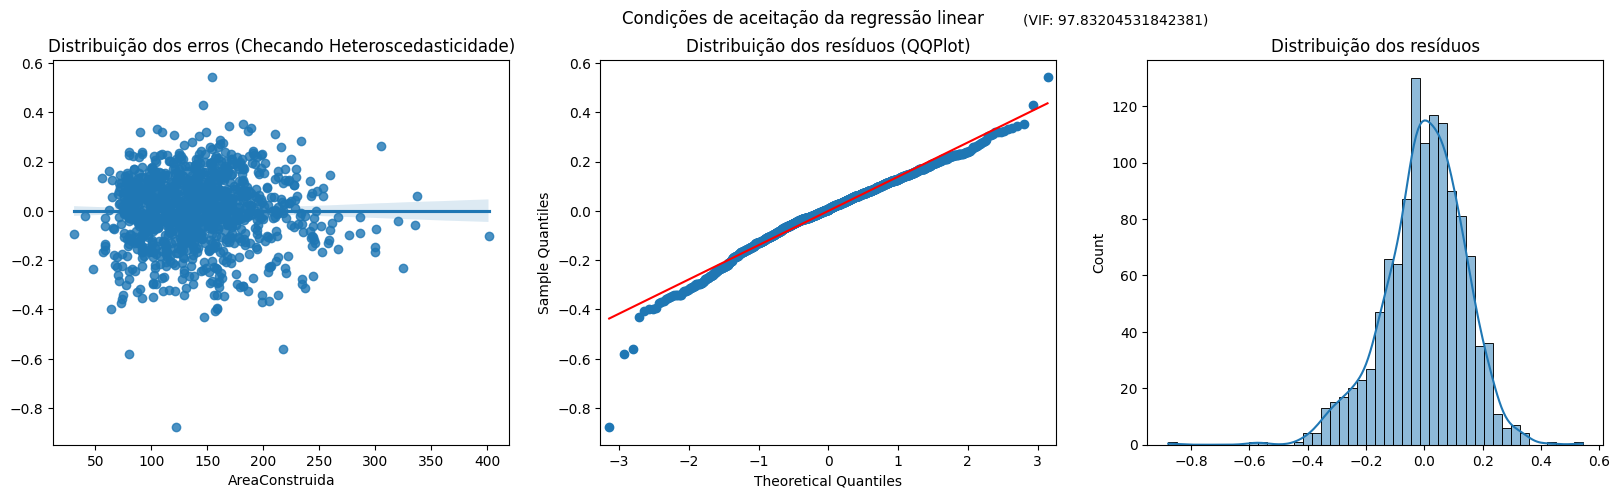

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(20,5), facecolor='white') 
sns.regplot(x=df_dummies.AreaConstruida, y=model.resid, ax=axs[0])
sm.qqplot(model.resid, line="s", ax=axs[1])
sns.histplot(model.resid, kde=True, ax=axs[2])

axs[0].set_title('Distribuição dos erros (Checando Heteroscedasticidade)')
axs[1].set_title('Distribuição dos resíduos (QQPlot)')
axs[2].set_title('Distribuição dos resíduos')
fig.suptitle('Condições de aceitação da regressão linear')
fig.text(s='(VIF: {})'.format(vif.VIF.sum()), y=0.95, x=0.61)


### 4.4 Interpretação do modelo de regressão linear

In [19]:
round((np.exp(model.params[1:]) - 1)*100, 2)

AreaConstruida     0.29
AreaPorao          0.22
Ultima_Reforma    -0.22
CarrosGaragem     10.13
Condicao           6.21
Qualidade         10.59
dtype: float64

O aumento de 1m² na área construída aumenta o preço da residência em 0.29%

O aumento de 1m² na área do porão aumenta o preço da residência em 0.22%

O aumento de 1 ano desde a última reforma diminui o preço da residência em 0.22%

O aumento de 1 carro no espaço da garagem aumenta o preço da residência em 10.13%

A melhoria de 1 grau de condição aumenta o preço da residência em 6.21%

A melhoria de 1 grau de qualidade aumenta o preço da residência em 10.59%

## 5 - Utilizando RandomForest para uma melhor predição do valor do imóvel

O algoritmo de regressão linear dá boa explicabilidade sobre o modelo, mas o RandomForest pode alcançar melhores índices na predição, com um erro quadrático menor. Por ser um algoritmo não linear, o RF lida muito melhor com desbalancemantos nas variáveis numéricas e outros problemas que travam o modelo de regressão linear. Apesar da ótima performance do modelo de RF, sua interpretação é difícil, isso justifica o uso anterior do algoritmo de regressão linear para entendimento da constituição do valor do imóvel.

In [20]:
#Obtendo novamente as variáveis numéricas e categóricas do modelo, dessa vez a partir da base mais trabalhada

var_resp = 'PrecoVenda'

#Lista das variáveis numéricas
var_num = df.select_dtypes(include=["int", "float"]).columns.to_list()
var_num.remove(var_resp)
var_num.remove('logPrecoVenda')

#Lista das variáveis categóricas
var_cat = df.select_dtypes(exclude=["int", "float"]).columns.to_list()

### 5.1 - Criando os splits para treino, validação e teste do modelo

In [21]:
features = var_cat + var_num

(X_train, X_test, X_val,
y_train, y_test, y_val) = train_test_valid_split(df, features=features, target=var_resp, test_size=0.3, valid_size=0.5, random_state=31)

X_train, X_val, X_test = random_forest_preprocessing(X_train, X_val, X_test, y_train, categoricas=var_cat)


### 5.2 Rodando o baseline do RandomForest

O baseline do RandomForest retornou um R² de 0.88, com um erro quadrático médio de pouco mais de 22 mil em valor médio da habitação de pouco mais de 175 mil

In [22]:
rf_baseline = RandomForestRegressor(random_state=42)
# Treino
rf_baseline.fit(X_train, y_train)

y_val_baseline_pred = rf_baseline.predict(X_val)
baseline_report = metrics_report(y_val, y_val_baseline_pred, 'validation')
baseline_report

,metric,validation
0,RMSE,22948.80
1,MAE,16376.22
2,R^2,0.87
3,MAPE,0.10
4,Avg. target,175268.56
5,Avg. Prediction,176033.85


### 5.3 Descobrindo as melhores condições de alguns hiperparametros para o modelo

O baseline do RandomForest já apresenta um resultado relativamente satisfatório, uma vez que o RMSE é tolerável e o valor predito é bem próximo do valor médio. Além disso, o R² encontrado no modelo foi bem alto. Uma última etapa desse trabalho envolve a hiperparametrização a partir dos testes dos hiperparâmetros. Para cada parâmetro são testadas n possibilidades, sendo admitida a possibilidade na qual o valor de RMSE é menor

In [23]:
#Testando o número de estimadores (as "árvores" da floresta)

rmse_final = 0
n_estimators_final = 0

for n_estimator in [5, 10, 20, 40, 80, 120, 160, 200, 240]:
    print('número de estimadores: {}'.format(n_estimator))
    rf_model = RandomForestRegressor(n_estimators=n_estimator,random_state=42)
    rf_model.fit(X_train, y_train)
    y_val_model_pred = rf_model.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val, y_val_model_pred))

    if (rmse_final == 0) or (rmse < rmse_final):
        rmse_final = rmse
        n_estimators_final = n_estimator

print('rmse: {}'.format(rmse_final) + ' melhor número de features: {}'.format(n_estimator))

número de estimadores: 5
número de estimadores: 10
número de estimadores: 20
número de estimadores: 40
número de estimadores: 80
número de estimadores: 120
número de estimadores: 160
número de estimadores: 200
número de estimadores: 240
rmse: 22761.48480355246 melhor número de features: 240


In [24]:
#Testando o número de features maximo (o tanto de variáveis do modelo que as árvores considerarão)

rmse_final = 0
n_features_final = 0

for max_feature in np.arange(0.1, 1, 0.05):
    print('número de features contabilizadas: {}'.format(max_feature))
    rf_model = RandomForestRegressor(max_features=max_feature,random_state=42)
    rf_model.fit(X_train, y_train)
    y_val_model_pred = rf_model.predict(X_val)
    rmse = math.sqrt(mean_squared_error(y_val, y_val_model_pred))

    if (rmse_final == 0) or (rmse < rmse_final):
        rmse_final = rmse
        n_features_final = max_feature

print('rmse: {}'.format(rmse_final) + ' melhor número de features: {}'.format(n_features_final))

número de features contabilizadas: 0.1
número de features contabilizadas: 0.15000000000000002
número de features contabilizadas: 0.20000000000000004
número de features contabilizadas: 0.25000000000000006
número de features contabilizadas: 0.30000000000000004
número de features contabilizadas: 0.3500000000000001
número de features contabilizadas: 0.40000000000000013
número de features contabilizadas: 0.45000000000000007
número de features contabilizadas: 0.5000000000000001
número de features contabilizadas: 0.5500000000000002
número de features contabilizadas: 0.6000000000000002
número de features contabilizadas: 0.6500000000000001
número de features contabilizadas: 0.7000000000000002
número de features contabilizadas: 0.7500000000000002
número de features contabilizadas: 0.8000000000000002
número de features contabilizadas: 0.8500000000000002
número de features contabilizadas: 0.9000000000000002
número de features contabilizadas: 0.9500000000000003
rmse: 19892.96496276272 melhor número

### 5.4 Criando modelo final com número ideal de features e estimadores

A partir dos testes realizados anteriormente foram escolhidos 240 estimadores e leitura de 1/3 das colunas da base

In [93]:
#Teste
rf_model_final = RandomForestRegressor(n_estimators=240, max_features=0.3)
rf_model_final.fit(X_train, y_train)
y_test_model_final = rf_model_final.predict(X_test)
baseline_report = metrics_report(y_test, y_test_model_final, 'teste')
baseline_report

,metric,teste
0,RMSE,19624.17
1,MAE,13352.12
2,R^2,0.90
3,MAPE,0.09
4,Avg. target,169394.04
5,Avg. Prediction,170048.73


In [25]:
#Validação
rf_model_final = RandomForestRegressor(n_estimators=240, max_features=0.3)
rf_model_final.fit(X_train, y_train)
y_val_model_final = rf_model_final.predict(X_val)
baseline_report = metrics_report(y_val, y_val_model_final, 'validation')
baseline_report

,metric,validation
0,RMSE,20306.62
1,MAE,14459.51
2,R^2,0.90
3,MAPE,0.09
4,Avg. target,175268.56
5,Avg. Prediction,175168.98


## 6 Conclusão

Foram testados dois modelos de Machine Learning para a predição e interpretação dos valores dos imóveis, baseados nos algorítmos de Regressão Linear e RandomForest. O Algoritmo de regressão linear ajudou na interpretação da constituição do valor das habitações com bom índice de explicabilidade: a partir da verificação do modelo é possível identificar que além do aumento da área, a melhoria da qualidade na habitação, a criação de vagas de garagem e a reforma recente ajudam a aumentar o valor do imóvel. A inserção de mais espaço na garagem e a melhoria na qualidade do edifício têm impacto mais rápido no valor do imóvel.
O modelo de RandomForest considerou a variável absoluta do valor do imóvel e chegou a um bom índice de predição após hiperparametrização, com erro quadrático de cerca de 20 mil, e valor do imóvel em 170 mil. O erro quadrático ainda pode ser refinado a partir de uma hiperparametrização mais densa.